In [1]:
import sys
sys.path.insert(0, 'visualization.py')
sys.path.insert(0, 'utils.py')

In [2]:
# /!\ Before running the lab make sure every additional libraries is installed 

# Import local libraries
from visualization import *
from utils import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Task n°1


This exercise is about showing measurements made by the Intelligent Road-Side Unit (IRSU) positioned at the center of the intersection:
- 1 point clouds collected by a 32-channel LiDAR

The functions you need to modify are located in:
-  box_to_corner -> visualization.py 

-  get_boxes_in_actor_frame -> utils.py

In [3]:
n_frame = 0
actor = 'ego_vehicle'

irsu_points = get_point_cloud(n_frame, actor)
irsu_boxes = get_boxes_in_actor_frame(n_frame, actor)
print(irsu_boxes.shape)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]


show_objects(irsu_points[:,:3], irsu_boxes[:,:7], box_colors)

(10, 8)


# Task n°2

This exercise demonstrates how the field of view and perception range of a vehicle can be enhanced by receiving data from other vehicles and the IRSU.

The functions you need to modify are:
-  box_to_corner (already done in task 1) -> visualization.py
-  get_available_point_clouds, get_available_boxes_in_ego_frame, get_boxes_in_actor_frame(already done in task 1) -> utils.py

In [4]:
n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind" ,"infrastructure",]#

merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

show_objects(merged_points, irsu_boxes[:,:7], box_colors)

# Task n°3

Build a BEV occupancy grid of the environment

A main challenge in perception on point clouds is their unordered nature which hinders the application of the Convolution operation, thus preventing the use of many wonders in the world of image-based perception. An effective way to get around this challenge is to convert point clouds to BEV images. In other word, to look at a point cloud from the top-view which is what you are going to do in this exercise.

The functions you need to modify are :
-  box_to_pixels, points_to_pixels-> visualization.py
-  filter_points -> utils.py

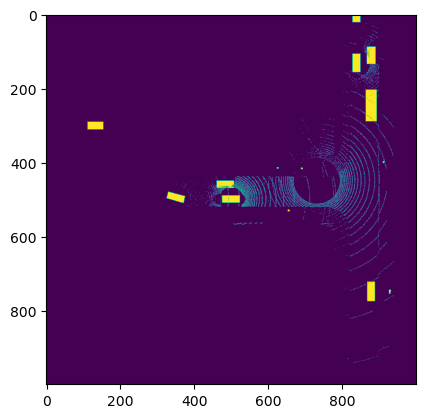

In [7]:

n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind","infrastructure",]
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

# ------------------ Get Waypoints that belongs to the ground floor ------------------
points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # xmin, ymin, zmin, xmax, ymax, zmax (meters) around ego_vehicle

filtered_points = filter_points(merged_points, points_range)
show_objects(filtered_points, irsu_boxes[:,:7], box_colors)

# ------------------  Build BEV image  ------------------  
bev_resolution = 0.1 # meters / pixel
bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)
bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))

# ------------------  Project bbox of actors on the image  ------------------  

#box_mask = box_to_pixels(irsu_boxes[:,:7], bev_imsize, bev_resolution)
#bev_occupancy[box_mask > 0] = 255

for i in range(irsu_boxes.shape[0]):
    box_mask = box_to_pixels(irsu_boxes[i:i+1, :7], bev_imsize, bev_resolution)
    bev_occupancy[box_mask > 0] = 255

# ------------------  Project navigable space on the image ------------------  
navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)

for pixel in navigable_space:
    bev_occupancy[round(pixel[1]), round(pixel[0])] = 150


plt.imshow(bev_occupancy)


# Task n°4: 
Segment points according to object's class

In [9]:
def segment_object_class(irsu_boxes):
    
    car_obj = np.empty((0, 7))
    truck_obj = np.empty((0, 7))
    ped_obj = np.empty((0, 7))
    moto_obj = np.empty((0, 7))

    for i in (irsu_boxes):
        class_label = i[-1]
        if class_label == 0.0:
            car_obj = np.vstack((car_obj, i[0:7]))
        elif class_label == 1.0:
            truck_obj = np.vstack((truck_obj, i[0:7]))
        elif class_label == 2.0:
            moto_obj= np.vstack((moto_obj, i[0:7]))
        else:
            ped_obj= np.vstack((ped_obj, i[0:7]))
            
            
    return car_obj, truck_obj, moto_obj, ped_obj

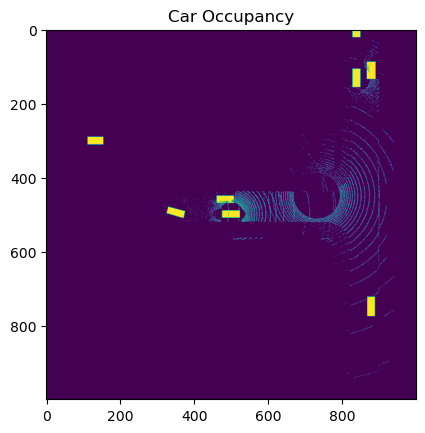

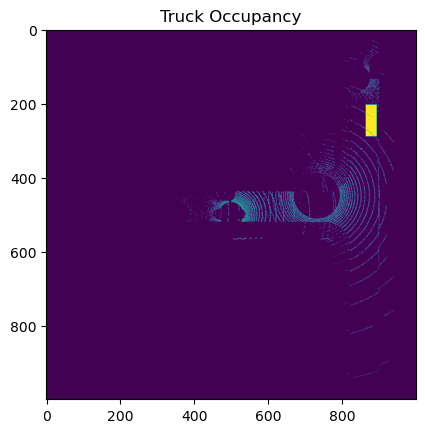

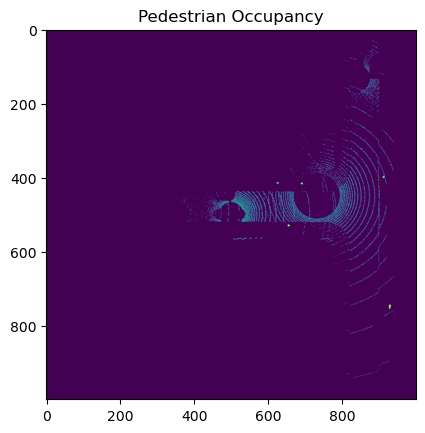

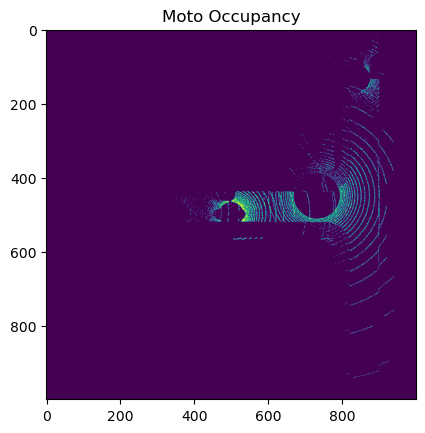

In [10]:
# Each detection is attached with one class label, use it to filter out the detections of interest (e.g. vehicles, pedestrians, etc.)

# Each detection is attached with one class label, use it to filter out the detections of interest (e.g. vehicles, pedestrians, etc.)

n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind","infrastructure",]
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)    

car_obj, truck_obj, moto_obj, ped_obj = segment_object_class(irsu_boxes)

# ------------------  Build BEV image  ------------------  
bev_resolution = 0.1 # meters / pixel
bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)

bev_occupancy_car = np.zeros((bev_imsize[1], bev_imsize[0]))
bev_occupancy_truck = np.zeros((bev_imsize[1], bev_imsize[0]))
bev_occupancy_ped = np.zeros((bev_imsize[1], bev_imsize[0]))
bev_occupancy_moto = np.zeros((bev_imsize[1], bev_imsize[0]))

# ------------------  Project bbox of actors on the image  ------------------  

for i in range(car_obj.shape[0]):
    box_mask_car = box_to_pixels(car_obj[i:i+1, :7], bev_imsize, bev_resolution)
    bev_occupancy_car[box_mask_car > 0] = 255
    
for i in range(truck_obj.shape[0]):
    box_mask_truck = box_to_pixels(truck_obj[i:i+1, :7], bev_imsize, bev_resolution)
    bev_occupancy_truck[box_mask_truck > 0] = 255
    
for i in range(ped_obj.shape[0]):
    box_mask_ped = box_to_pixels(ped_obj[i:i+1, :7], bev_imsize, bev_resolution)
    bev_occupancy_ped[box_mask_ped > 0] = 255
    
for i in range(moto_obj.shape[0]):
    box_mask_moto = box_to_pixels(moto_obj[i:i+1, :7], bev_imsize, bev_resolution)
    bev_occupancy_moto[box_mask_moto > 0] = 255

# ------------------  Project navigable space on the image ------------------
navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution) # Da controllare

for pixel in navigable_space:
    bev_occupancy_car[round(pixel[1]), round(pixel[0])] = 150
    bev_occupancy_truck[round(pixel[1]), round(pixel[0])] = 150
    bev_occupancy_ped[round(pixel[1]), round(pixel[0])] = 150
    bev_occupancy_moto[round(pixel[1]), round(pixel[0])] = 150


plt.figure()
plt.imshow(bev_occupancy_car)
plt.title("Car Occupancy")

plt.figure()
plt.imshow(bev_occupancy_truck)
plt.title("Truck Occupancy")

plt.figure()
plt.imshow(bev_occupancy_ped)
plt.title("Pedestrian Occupancy")

plt.figure()
plt.imshow(bev_occupancy_moto)
plt.title("Moto Occupancy")

plt.show()

